last edited by Claire Valva on October 15, 2018

# Spectral analysis performed on 40.5N data
end of notebook shows average fft magnitude vs. omega
reminders to self: remember zero padding when applying the ifft relationship


##### to do (non urgent/does not affect results): 
edit function which detrends to prevent warnings/for faster code, get rid of repetition in grouping/individual season analysis

##### to do: wavenumber vs. frequency plot, fix sanity checks to correspond with new windowing, decide if want to split into more pieces

In [1]:
# !jupyter nbconvert --to=script 40.5N-spectralanalysis.ipynb

In [2]:
#set whether or not to reload data, set to true/false
#or use data saved from an old session
do_trends = False #should detrend again?
run_fresh = False #should I reupload file/original data?
save_results = True #should I save the fft results for opening in another notebook?

In [3]:
#import packages
import numpy as np
from scipy.signal import get_window, csd
from scipy.signal.windows import hann, hanning, nuttall, flattop
from scipy.fftpack import fft, ifft, fftfreq, fftshift, ifftshift
import matplotlib.pyplot as plt
import scipy.integrate as sciint
import pandas as pd
import datetime
import matplotlib.cm as cm
from math import pi
import matplotlib.ticker as tck
import datetime
from sympy import solve, Poly, Eq, Function, exp, re, im
from PyEMD import EMD
from netCDF4 import Dataset, num2date # This is to read .nc files and time array
from scipy.optimize import fsolve
import statsmodels.api as sm
from IPython.display import display, Markdown, Latex
import random
import matplotlib.colors as colors
from seaborn import cubehelix_palette #for contour plot colors

In [4]:
#import own functions from functions_forspectralanalysis.py
#functions are based off of those in spectral_analysis_tests.ipynb 
#but edited so that they can be used in multiple notebooks
from functions_forspectralanalysis import *

/home/clairev/python-climate-data-processing/submission_from_claire/40.5N-processing/functions_forspectralanalysis.py:84: RuntimeWarning: divide by zero encountered in true_divide
  zonal_spacing = 1/zonal_spacing


## Import and edit file

In [5]:
#import file
filepath = '/home/clairev/uncategorized-data/1979-2016-300hPa-40.5N-z.nc' # Location of the file
fileobj = Dataset(filepath, mode='r')

# Check what's in there
fileobj

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    dimensions(sizes): longitude(240), time(55520)
    variables(dimensions): float32 z(time,longitude)
    groups: 

In [6]:
#set indicies/number of things
number_entries = int(fileobj.dimensions['time'].size)
number_days = int(number_entries / 4)
number_lon = fileobj.dimensions['longitude'].size
year_number = 2016 - 1979 + 1

year_list = [1979 + i for i in range(2017-1979)]

In [7]:
#load coordinates
#so height[i] is the geopotential height at a given time
height = fileobj.variables['z'][:]
g_inv = 1/9.81
height = height*g_inv

In [8]:
#create time array
time_list = []
for i in range(0,55520):
    time_list.append(i*6)
tunit = "hours since 1979-01-01T00:00:00Z"
tarray = num2date(time_list,units = tunit,calendar = 'gregorian')

#create longitude array
lon_increment = 1.5 # The increment of each longitude grid is 1.5
lon_list = [i * lon_increment for i in range(240)]

In [9]:
#tarray to dataframe
month_index = [entry.month for entry in tarray]
season_index = [season_sort(entry.month) for entry in tarray]
year_index = [entry.year for entry in tarray]

#pull together in a dataframe?
d = {"index" : list(range(0,55520)), "year": year_index, "season": season_index}

zone_index = pd.DataFrame(d)

In [10]:
if run_fresh:

#get lists and then merge together as a dataframe
    lon_list_df = [lon_list[k]
               for i in range(number_entries)
               for k in range(number_lon)]

    z_temp = [height[i][k]
              for i in range(number_entries)
              for k in range(number_lon)]

    date_list = [tarray[i]
               for i in range(number_entries)
               for k in range(number_lon)]
    
    #make this a dataframe
    d = {'datetime' : date_list, 'lon': lon_list_df,
                    'z' : z_temp}
    geopot_df = pd.DataFrame(d)
    
    #get day/month/year separately for groupby
    geopot_df['month'] = geopot_df['datetime'].apply(lambda x: x.month)
    geopot_df['day'] = geopot_df['datetime'].apply(lambda x: x.day)
    geopot_df['year'] = geopot_df['datetime'].apply(lambda x: x.year)
    
    #sort into seasons    
    geopot_df["season"] = geopot_df["month"].apply(lambda x: season_sort(x))
    
    
    # Create storage object with filename `processed_data`
    data_store = pd.HDFStore('processed_data.h5')

    # Put DataFrame into the object setting the key as 'preprocessed_df'
    data_store['preprocessed_geopot'] = geopot_df
    data_store.close()
    
else:
        # Access data store
    data_store = pd.HDFStore('processed_data.h5')

    # Retrieve data using key
    geopot_df = data_store['preprocessed_geopot']
    data_store.close()

## Perform zonal fft

In [11]:
#get fft results at each date over entire longitude
fft_zonal_result = [geopot_fft(height[k]) 
                    for k in range(number_entries)]

In [12]:
#get fft that is zero padding for plotting
fft_zonal_results_zero = [geopot_fft_zero(height[k], length = 372)
                         for k in range(number_entries)]

/home/clairev/anaconda3/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


In [13]:
wavenum_zone = fftfreq(372, 1.5)
wavenum_zone = 1/wavenum_zone
wavenum_zone = 372*1.5 / wavenum_zone

/home/clairev/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


/home/clairev/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


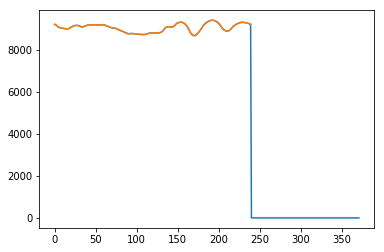

In [14]:
#check if zero padded looks the same as not zero padded
check_zero = ifft(fft_zonal_results_zero[2])
check_norm = ifft(fft_zonal_result[2])

#plot it -- seems like it works or close enough
plt.plot(check_zero)
plt.plot(check_norm)
plt.show()

## Perform time fft

### detrending

detrend all data using results from zonal fft

In [15]:
#get list of years and seasons to perform transform/detrend on
years = range(1979,2017)
seasons = ["winter", "spring", "summer", "fall"]

#### define some functions which depend on the files imported earlier

In [16]:
def trendsfordf(year, season):
    frame = geopot_df.query(query_string(year, season, 9))
    
    trend_list = [pairwavenum(k, frame, tarray, fft_zonal_result) 
                  for k in range(len(zonal_spacing))]
    
    return(trend_list)

##### this function gets a lot of runtime warnings, likely from the fsolve would be nice to fix later on, but causes no errors as far as can be told currently

In [17]:
def coeff_subtract(time, frame, tarray, fft_zonal_result, trend_list):
    #since gettimes depends on frame, get frame first
    
    #get first and last timestamp
    tmin, tmax = gettimes(frame, tarray)
 
    #get the time steps at the beginning and end of the seasons
    iter_list = time - tmin
    
    #get the results and then subtract the list
    results = fft_zonal_result[time]
    tosub = [sublist[1][iter_list - 1] for sublist in trend_list]
    
    results = results - tosub
    
    return results

In [18]:
def trendsfordf(year, season):
    frame = geopot_df.query(query_string(year, season, 9))
    
    #get trends
    trend_list = [pairwavenum(k, frame, tarray, fft_zonal_result) 
                  for k in range(len(zonal_spacing))]
    
    tmin, tmax = gettimes(frame, tarray)
    
    #adjust the list
    adjusted_list = [coeff_subtract(time, frame, tarray, fft_zonal_result, trend_list) for time in range(tmin, tmax+tmin)]
    
    #perform ifft on the list
    adjusted_list_ifft = [ifft(sublist) for sublist in adjusted_list]
    
    return(season, year, trend_list, adjusted_list, adjusted_list_ifft)

In [19]:
#get the trends in fourier coefficients
if do_trends == True:
    trends_all_list = [trendsfordf(time, season) for season in seasons
                       for time in years]
    
    import pickle

    file_Name = "test_trends_pickle"
    file_pickle = open(file_Name,'wb') 

    pickle.dump(trends_all_list,file_pickle)
    file_pickle.close()

In [20]:
if do_trends == False:
    import pickle
    
    file_Name = "test_trends_pickle"
    
    file_pickle = open(file_Name, "rb")
    
    trends_all_list = pickle.load(file_pickle)

note that the structre of trends_all_list is:

trends = [time, season, trends, adjusted forier coeffs, ifft of adjusted forier coeffs] * 152

where time is a year
season is a season
trends for that time and season are 240 entries of changing trends

In [21]:
#pull everything out of the list
season_index = [sublist[0] for sublist in trends_all_list]
year_index = [sublist[1] for sublist in trends_all_list]
trend_index = [sublist[2] for sublist in trends_all_list]
adjcof_index = [sublist[3] for sublist in trends_all_list]
untrend_index = [sublist[4] for sublist in trends_all_list]

In [22]:
#flatten list of detrended z values
flatten_df_untrend = [item for sublist in untrend_index for item in sublist]
flatten_df_untrend = [item for sublist in flatten_df_untrend for item in sublist]

In [23]:
#get list of same length for df binding - season, year, lon lists
season_df_list = []
year_df_list = []
lon_df_list = []

for i in range(len(untrend_index)):
    for j in range(len(untrend_index[i])):
        for k in range(240):
            entry = season_index[i]
            yr = year_index[i]
            lon = lon_list[k]
            
            season_df_list.append(entry)
            year_df_list.append(yr)
            lon_df_list.append(lon)

In [24]:
d = {"season": season_df_list, "year": year_df_list,
     "lon": lon_df_list, "adj_z": flatten_df_untrend}

untrend_df = pd.DataFrame(d)

### check if the detrending provided results that look sensible

/home/clairev/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


<Figure size 432x288 with 0 Axes>

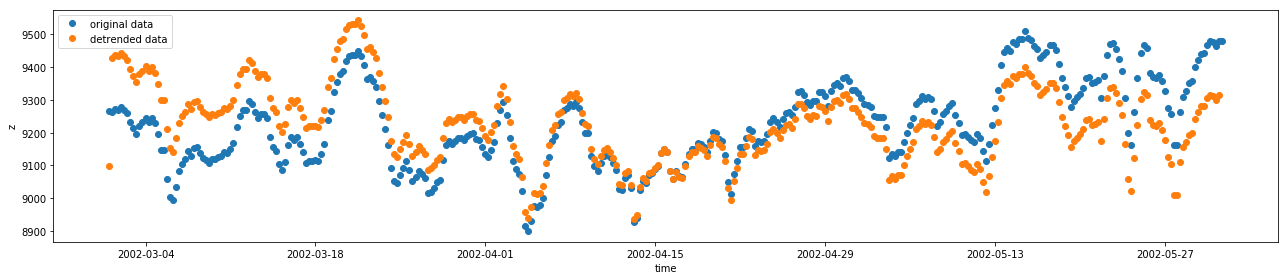

In [25]:
#slice some random part of original dataframe and detrended to see if have similar shape
year_test = 2002
season_test = "spring"

orig_data = geopot_df.query(query_string(year_test, season_test, 9))
untrend_data = untrend_df.query(query_string(year_test, season_test, 9))

#plot the results
#compare them again!
plt.clf();
plt.figure(figsize=(18,4))
plt.plot_date(orig_data["datetime"], orig_data["z"], label = "original data")
plt.plot_date(orig_data["datetime"][:367], untrend_data["adj_z"], label = "detrended data")
plt.xlabel('time')
plt.ylabel('z')
plt.legend()
plt.tight_layout()

### Perform transform on the detrended data
window used in this case is hanning, where the window size is determined by the length of data but everything is zero padded to have the same/maximum length as to not deal with leap years

In [26]:
#choose length of trend that is wanted
#made all the same for easier comparative purposes
want_size = 372
M = 372

In [27]:
#get spacing
time_spacing_list = fftfreq(want_size, 0.25)
wavenum_time = 1/time_spacing_list
wavenum_time = 93 / wavenum_time

/home/clairev/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


In [28]:
def splitter(data, over_per):
    #with a given percent overlap, splits the data
    len_dat = len(data)
    
    if over_per == 0:
        third = int(len_dat/3)
        
        len1 = data[0:third]
        len2 = data[third:third + third]
        len3 = data[third + third:len_dat]
    else:
        overlap_recip = 1/over_per
        len_part = len_dat / overlap_recip
        endpart1 = int(len_part)
        startpart2 = int(endpart1*(1-over_per))
        endpart2 = len_part*over_per + len_part
        endpart2 = int(endpart2)
    
        #test overlaps to make sure it looks right
        len1 = data[0:endpart1]
        len2 = data[startpart2:endpart2]
        len3 = data[endpart1:len_dat]
    
    return len1, len2, len3

In [29]:
def windowapp(data, over_per = 0.5, window = "hann"):
    
    #splits data into 3 lengths, windows, performs ffts, and then averages
    
    len1, len2, len3 = splitter(data, over_per)
    
    total_length = len(data)
    pad_length = len(data) - len(len1)
    pad_length = int(pad_length/2)
    pad_list = [0 for i in range(pad_length)]
    
    listed = [len1, len2, len3]
    
    if window == "none":
        window = "boxcar"
    
    windowed = [length*get_window(window, len(length), fftbins = True) for length in listed]
    
    len1 = np.concatenate([windowed[0], pad_list, pad_list], axis = 0)
    len2 = np.concatenate([pad_list,windowed[1],pad_list])
    len3 = np.concatenate([pad_list,pad_list,windowed[2]])
    
    listed = [len1, len2, len3]
    
    ffts = [fft(length,n = M ) for length in listed]
    
    
    ffts = np.average(ffts, axis = 0)
    
    return ffts

##### note that the 3 cells below are old windowing functions saved to be used in sanity checks but not the full analysis, as they do not incorporate the overlapping windows

In [30]:
def time_fft_window(numbers):
    #gets the time fft with same zero padding for all slices, uses hanning window
    
    num_entries = len(numbers)
    window = hann(num_entries, sym = False)
    fft_for = numbers*window
    fft_coeff = fft(fft_for, n = want_size) 
    fft_withgain = fft_coeff / 0.5
    
    return(fft_withgain)

In [31]:
def time_fft_window_nopad(numbers):
    #gets the time fft with same zero padding for all slices, uses hanning window
    
    num_entries = len(numbers)
    window = hann(num_entries, sym = False)
    fft_for = numbers*window
    fft_coeff = fft(fft_for, n = num_entries) 
    fft_withgain = fft_coeff / 0.5
    
    return(fft_withgain)

In [32]:
def time_fft_nowindow(numbers):
    #gets time fft (same as time_fft_window()) but with no hanning window
    
    num_entries = len(numbers)
    fft_for = numbers
    fft_coeff = fft(fft_for, n = want_size)
    ck_coeff = fft_coeff/want_size
    
    return(fft_coeff)

##### compare results of windowed vs. no window functions and window setting sanity check

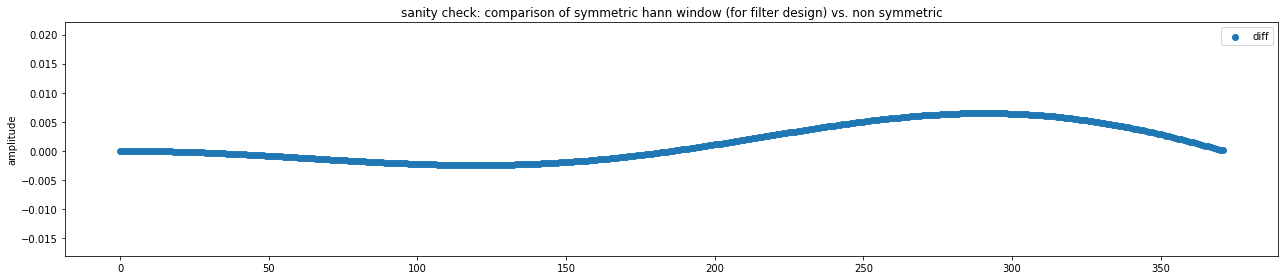

In [33]:
#plot the ifft
proxy_x = list(range(372))

plt.figure(figsize=(18,4))
plt.scatter(proxy_x, hann(372, sym = False) - hann(372, sym = True), label = "diff")
plt.ylabel('amplitude')
plt.legend()
plt.title("sanity check: comparison of symmetric hann window (for filter design) vs. non symmetric")
plt.tight_layout()

/home/clairev/anaconda3/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x
/home/clairev/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:553: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


<Figure size 432x288 with 0 Axes>

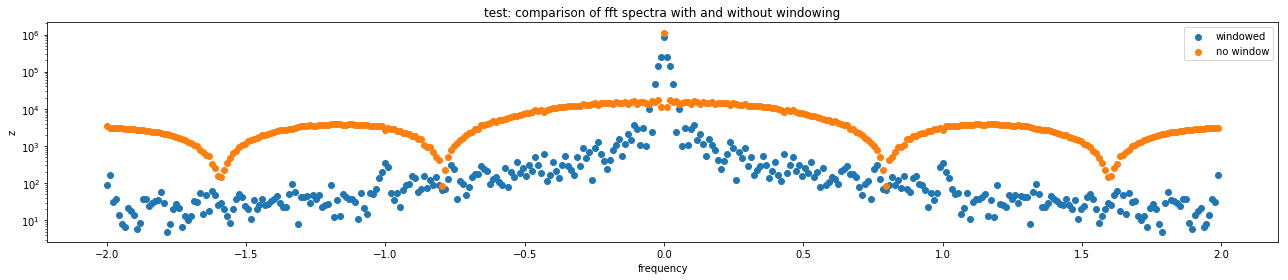

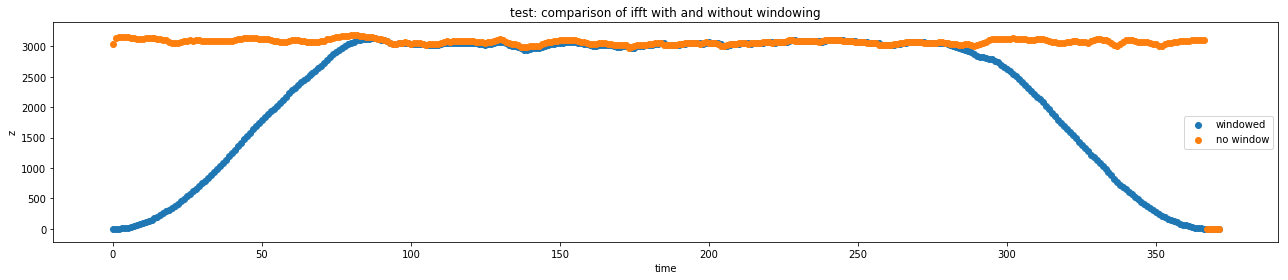

In [34]:
#use same test season as in the detrend sanity check
untrend_data = untrend_df.query(query_string(year_test, season_test, 9))
untrend_data = list(untrend_data["adj_z"])

nowind_test = windowapp(untrend_data, 0, "none")
wind_test = windowapp(untrend_data, 0.5, "hann")

#plot them with ifft
nowind_ifft_test = ifft(nowind_test)
wind_ifft_test = ifft(wind_test)

#get proxy x for plotting
proxy_freq = fftfreq(372, 0.25)

#plot the spectra
plt.clf();
plt.figure(figsize=(18,4))
plt.scatter(proxy_freq, np.abs(wind_test), label = "windowed")
plt.scatter(proxy_freq, np.abs(nowind_test), label = "no window")
plt.xlabel('frequency')
plt.ylabel('z')
plt.yscale("log")
plt.legend()
plt.title("test: comparison of fft spectra with and without windowing")
plt.tight_layout()

#plot the ifft
plt.figure(figsize=(18,4))
plt.scatter(proxy_x, wind_ifft_test, label = "windowed")
plt.scatter(proxy_x, nowind_ifft_test, label = "no window")
plt.xlabel('time')
plt.ylabel('z')
plt.legend()
plt.title("test: comparison of ifft with and without windowing")
plt.tight_layout()

### Complete the fft

In [35]:
#complete fft
grouped_untrend = untrend_df.groupby(["season","year","lon"])
grouped_z = grouped_untrend["adj_z"]

fft_grouped_wind_old = grouped_z.apply(time_fft_window) #for sanity checks
fft_grouped_wind = grouped_z.apply(windowapp) #for sanity checks

fft_grouped_wind_padtest = grouped_z.apply(time_fft_window_nopad) #for 0 padding sanity check
fft_grouped_nowind = grouped_z.apply(time_fft_nowindow) #for no window sanity check 

/home/clairev/anaconda3/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


In [36]:
#get indexing of groups
names = grouped_untrend.apply(lambda x: x.name)

In [37]:
def get_ind(match, sublist):
    #function gets indices of the sublist that equal the match term
    toreturn = [j for j in range(len(sublist)) if sublist[j] == match]
    return toreturn

In [38]:
#get list of year/seasons/longitudes
time_fft_seasons = [sublist[0] for sublist in names]
time_fft_year = [sublist[1] for sublist in names]
time_fft_lon = [sublist[2] for sublist in names]

#get lists of indicies
lon_index_time = [get_ind(k, time_fft_lon) for k in lon_list]
season_index_time = [get_ind(match, time_fft_seasons) for match in seasons]
year_index_time = [get_ind(year, time_fft_year) for year in year_list]

In [39]:
def condition_func_wint(i):
    #this function gets the winter indices at longitude index i, not for other seasons bc months in different years 
    results = i in winter_indices 
    return(results)

In [40]:
#want to mean over time, also make sure not to use the first summer
winter_indices, spring_indices, summer_indices, fall_indices = season_index_time

#get matches for winter and longitude, where year != 1979
winter_lon_indices = [[i for i in lon_index_time[j] if condition_func_wint(i)] 
                      for j in range(len(lon_list))]

spring_lon_indices = [[i for i in lon_index_time[j] if i in spring_indices]
                     for j in range(len(lon_list))]

summer_lon_indices = [[i for i in lon_index_time[j] if i in summer_indices]
                     for j in range(len(lon_list))]

fall_lon_indices = [[i for i in lon_index_time[j] if i in fall_indices]
                     for j in range(len(lon_list))]

In [41]:
def get_avglist(indices, valuelist, ax = 0):
    #from indices and the value list, returns the list with the same indices
    toavg = [valuelist[i] for i in indices]
    averaged = np.average(toavg, axis = ax)
    return averaged

In [42]:
#now get the averages of each spectrum for the lists
winter_ffts = [get_avglist(sublist,fft_grouped_wind) for sublist in winter_lon_indices]
spring_ffts = [get_avglist(sublist,fft_grouped_wind) for sublist in spring_lon_indices]
fall_ffts = [get_avglist(sublist,fft_grouped_wind) for sublist in fall_lon_indices]
summer_ffts = [get_avglist(sublist,fft_grouped_wind) for sublist in summer_lon_indices]

#until slight rewrite to make less repetitive
all_ffts = [winter_ffts, spring_ffts, summer_ffts, fall_ffts]

In [43]:
#optionally combine into a full array and pickle so can be used in another doc if needed
if save_results:
    #time fft
    raw_fft_results = [fft_grouped_wind, names]
    
    #zonal_fft
    season_zonal_fft = [[fft_zonal_result[i] for i in range(len(fft_zonal_result)) 
                     if season_sort(tarray[i].month) == label] for label in seasons]
    season_zonal_fft_avg = [np.average(sublist, axis = 0) for sublist in season_zonal_fft]
    total_zonal_fft_avg = np.average(fft_zonal_result, axis = 0)
    
    zonal_fft = [["seasonavg", season_zonal_fft_avg], ["totalavg", total_zonal_fft_avg]]
    
    all_fft_results = [raw_fft_results, zonal_fft]
    
    import pickle
    
    file_Name = "raw_fft_results_sept18"
    
    file_pickle = open(file_Name,'wb') 
    
    pickle.dump(all_fft_results,file_pickle)
    file_pickle.close()
    


### Dispersion relation plots

In [44]:
#names to dataframe
seasons_fordf = [item[0] for item in names]
years_fordf = [item[1] for item in names]
lon_fordf = [item[2] for item in names]

d = {"index": list(range(len(names))), "year":years_fordf, "season":seasons_fordf, "lon":lon_fordf}
time_index = pd.DataFrame(d)

In [45]:
#use groupby for matching?
grouped_index_time = time_index.groupby(["year","season"])["index"]
grouped_index_zone = zone_index.groupby(["year","season"])["index"]

names_time = grouped_index_time.apply(lambda x: x.name)
names_zone = grouped_index_zone.apply(lambda x: x.name)

In [46]:
#will store names and indices in a separate list
names_matched = []
indices_matched_time = []
indices_matched_zone = []


for name, group in grouped_index_time:
    for name2, group2 in grouped_index_zone:
        
        #store the indices of the matching categories
        if name == name2:
            
            names_matched.append(name)
            indices_matched_time.append(list(group))
            indices_matched_zone.append(list(group2))

In [47]:
#used matched indices to get the results
match_zones = [[fft_zonal_results_zero[j] for j in indices_matched_zone[i]] for i in range(len(names_matched))] 
match_times = [[fft_grouped_wind[j] for j in indices_matched_time[i]] for i in range(len(names_matched))] 

In [48]:
def flatten(l):
    #flattens lists
    return [item for sublist in l for item in sublist] 

In [49]:
def fft_2d(segment):
    #applies 2d fft to windowed data--
    i_list = [ifft(sublist) for sublist in segment]
    fft2d = np.fft.fft2(i_list)
    
    return(fft2d)

In [50]:
#apply 2d fft
d2_trans = [fft_2d(group) for group in match_times]

#get absolute value and log
d2_touse = [np.real(group) for group in d2_trans]

#get shifted grid and then transpose
shifted_grids = [fftshift([fftshift(part) for part in group]) for group in d2_touse]
t_grids = [np.transpose(group) for group in shifted_grids]

#def freq
frequencies = fftfreq(M, 0.25)

#### quick plot to look at symmetries

In [51]:
##get new test_grid for croppeds plot
crop_test = d2_trans[2]

#fft shift everything
crop_test = fftshift([fftshift(group) for group in crop_test])
cf_before = fftshift(frequencies)
cz_before = fftshift(zonal_spacing)

#set what you wanna crop
min_z = 10
min_f = 0.5

#crop the data for plotting
cropped = [[crop_test[i][j] for i in range(len(cz_before)) 
            if np.abs(cz_before[i]) < min_z]# and cz_before[i] != 0]
           for j in range(len(cf_before)) 
           if np.abs(cf_before[j]) < min_f]# and cf_before[j] != 0]

cropf = [counted for counted in cf_before if np.abs(counted) < min_f and counted != 0]
cropz = [cz_before[i] for i in range(len(cz_before)) 
            if np.abs(cz_before[i]) < min_z]# and cz_before[i] != 0]

In [52]:
##get dims of cropped
cfdim = len(cropped)
czdim = len(cropped[0])

##transpose the grid
cropped = np.asarray(cropped)
t_cropped = np.transpose(cropped)

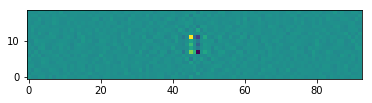

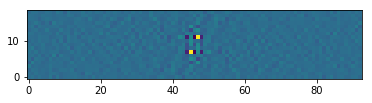

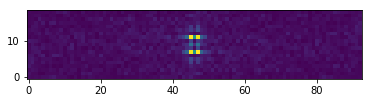

In [53]:
## plot it quickly without labeling to see where the symmetries are/aren't
## although for now are really only interested in the magnitude (the real) and not so much the phase (imaginary)
plt.clf();
plt.imshow(np.imag(t_cropped), origin = "lower")
plt.show()

plt.clf();
plt.imshow(np.real(t_cropped), origin = "lower")
plt.show()

plt.clf();
plt.imshow(np.abs(t_cropped), origin = "lower")
plt.show()

#### Try for a more descriptive version of the plot

In [81]:
#select a season for plotting
test_dat = d2_trans[50]
test_dat = fftshift([fftshift(group) for group in test_dat])

#set what you wanna crop
max_z = 20
max_f = 9

#crop the data, only keep the positive frequencies
cropped = [[test_dat[i][j] for i in range(len(cz_before)) 
            if cz_before[i] < max_z and cz_before[i] >= 0]
           for j in range(len(cf_before)) 
           if np.abs(cf_before[j]) < max_f]

cropf = [counted for counted in cf_before if np.abs(counted) < max_f]# and counted != 0]
cropz = [cz_before[i] for i in range(len(cz_before)) 
            if cz_before[i] < max_z and cz_before[i] >= 0]

x = cropf
y = cropz
X, Y = np.meshgrid(x,y)
X = np.flip(X)
Z = np.transpose(np.real(cropped))

<Figure size 432x288 with 0 Axes>

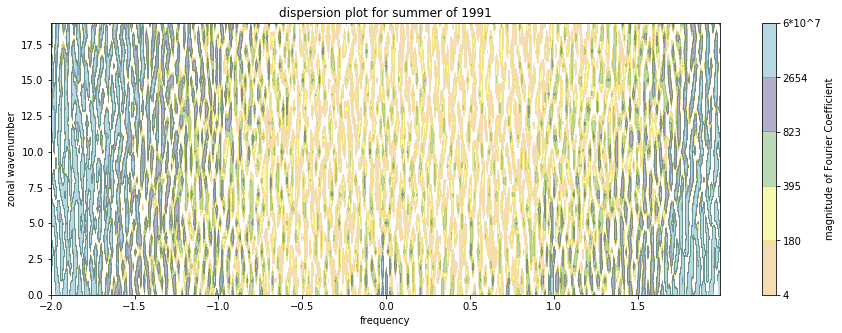

In [82]:
level_set = [np.percentile(Z, i*5) for i in range(1,21)]
level_set_less = [np.percentile(Z, i*10) for i in range(1,11) if i*10 >= 50]
colors_set = ["#eaa941", "#efef39", "#53a447", "#3b387f", "#48a2ba", "#ffffff"]

plt.clf();
plt.figure(figsize=(15, 5));
#CL = plt.contour(X,Y,Z, levels = level_set_less, alpha = 0.4)
CF = plt.contourf(X,Y,Z, levels = level_set_less, colors = colors_set, alpha = 0.4)

#set colorbars
CBI = plt.colorbar(CF, label = "magnitude of Fourier Coefficient")
labels = [int(entry) for entry in level_set_less]
labels[5] = "6*10^7"
CBI.set_ticklabels(labels)

plt.xlabel("frequency")
plt.ylabel("zonal wavenumber")
plt.title("dispersion plot for " + names_matched[50][1] + " of " + str(names_matched[50][0]))

name = 'disp_plots/test_01' + names_matched[50][1] + "_" +str(names_matched[50][0]) + '.png'
plt.savefig(name)


plt.show()

<Figure size 432x288 with 0 Axes>

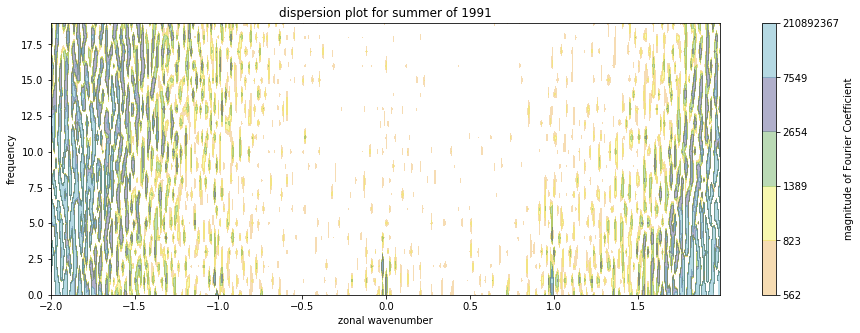

In [83]:
#try new levels?
level_set = [np.percentile(Z, i*5) for i in range(1,21)]
level_set_less = [np.percentile(Z, i*5) for i in range(1,21) if i*5 >= 75]
colors_set = ["#eaa941", "#efef39", "#53a447", "#3b387f", "#48a2ba", "#ffffff"]

plt.clf();
plt.figure(figsize=(15, 5));
#CL = plt.contour(X,Y,Z, levels = level_set_less, alpha = 0.4)
CF = plt.contourf(X,Y,Z, levels = level_set_less, colors = colors_set, alpha = 0.4)

#set colorbars
CBI = plt.colorbar(CF, label = "magnitude of Fourier Coefficient")
labels = [int(entry) for entry in level_set_less]
#labels[5] = "6*10^7"
CBI.set_ticklabels(labels)

plt.xlabel("zonal wavenumber")
plt.ylabel("frequency")
#plt.colorbar(label = "magnitude of Fourier coefficient")

plt.title("dispersion plot for " + names_matched[50][1] + " of " + str(names_matched[50][0]))

name = 'disp_plots/test_02' + names_matched[50][1] + "_" +str(names_matched[50][0]) + '.png'
plt.savefig(name)
plt.show()

In [84]:
#select a season for plotting
test_dat = d2_trans[50]

#set what you wanna crop
max_z = 30
max_f = 1.5

#crop the data, only keep the positive frequencies
cropped = [[test_dat[i][j] for i in range(len(zonal_spacing)) 
            if zonal_spacing[i] < max_z and zonal_spacing[i] >= 0]
           for j in range(len(frequencies)) 
           if np.abs(frequencies[j]) < max_f]

cropf = [counted for counted in frequencies if np.abs(counted) < max_f]# and counted != 0]
cropz = [zonal_spacing[i] for i in range(len(zonal_spacing)) 
            if zonal_spacing[i] < max_z and zonal_spacing[i] >= 0]

x = cropf
y = cropz
X, Y = np.meshgrid(x,y)
X = np.flip(X)
Z = np.transpose(np.abs(np.real(cropped)))

<Figure size 432x288 with 0 Axes>

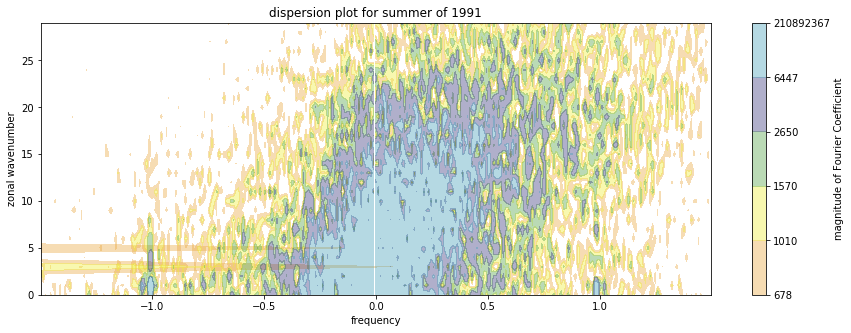

In [85]:
level_set = [np.percentile(Z, i*5) for i in range(1,21)]
level_set_less = [np.percentile(Z, i*10) for i in range(1,11) if i*10 >= 50]
colors_set = ["#eaa941", "#efef39", "#53a447", "#3b387f", "#48a2ba", "#ffffff"]

plt.clf();
plt.figure(figsize=(15, 5));
#CL = plt.contour(X,Y,Z, levels = level_set_less, alpha = 0.4)
CF = plt.contourf(X,Y,Z, levels = level_set_less, colors = colors_set, alpha = 0.4)

#set colorbars
CBI = plt.colorbar(CF, label = "magnitude of Fourier Coefficient")
labels = [int(entry) for entry in level_set_less]
#labels[5] = "6*10^7"
CBI.set_ticklabels(labels)

plt.xlabel("frequency")
plt.ylabel("zonal wavenumber")
plt.title("dispersion plot for " + names_matched[50][1] + " of " + str(names_matched[50][0]))

name = 'disp_plots/test_01' + names_matched[50][1] + "_" +str(names_matched[50][0]) + '.png'
plt.savefig(name)

plt.show()

In [86]:
#select a season for plotting
test_dat = d2_trans[50]

#set what you wanna crop
max_z = 30
max_f = 0.9

#crop the data, only keep the positive frequencies
cropped = [[test_dat[i][j] for i in range(len(zonal_spacing)) 
            if zonal_spacing[i] < max_z and zonal_spacing[i] >= 0]
           for j in range(len(frequencies)) 
           if np.abs(frequencies[j]) < max_f]

cropf = [counted for counted in frequencies if np.abs(counted) < max_f]# and counted != 0]
cropz = [zonal_spacing[i] for i in range(len(zonal_spacing)) 
            if zonal_spacing[i] < max_z and zonal_spacing[i] >= 0]

x = cropf
y = cropz
X, Y = np.meshgrid(x,y)
X = np.flip(X)
Z = np.transpose(np.abs(np.real(cropped)))

<Figure size 432x288 with 0 Axes>

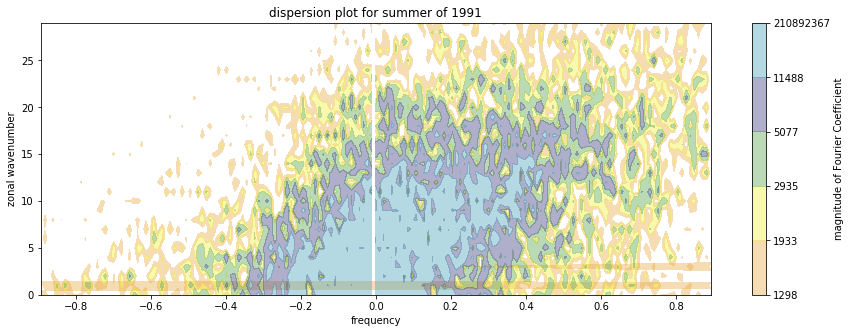

In [87]:
level_set = [np.percentile(Z, i*5) for i in range(1,21)]
level_set_less = [np.percentile(Z, i*10) for i in range(1,11) if i*10 >= 50]
colors_set = ["#eaa941", "#efef39", "#53a447", "#3b387f", "#48a2ba", "#ffffff"]

plt.clf();
plt.figure(figsize=(15, 5));
#CL = plt.contour(X,Y,Z, levels = level_set_less, alpha = 0.4)
CF = plt.contourf(X,Y,Z, levels = level_set_less, colors = colors_set, alpha = 0.4)

#set colorbars
CBI = plt.colorbar(CF, label = "magnitude of Fourier Coefficient")
labels = [int(entry) for entry in level_set_less]
#labels[5] = "6*10^7"
CBI.set_ticklabels(labels)

plt.xlabel("frequency")
plt.ylabel("zonal wavenumber")
plt.title("dispersion plot for " + names_matched[50][1] + " of " + str(names_matched[50][0]))

name = 'disp_plots/test_01' + names_matched[50][1] + "_" +str(names_matched[50][0]) + '.png'
plt.savefig(name)

plt.show()

<Figure size 432x288 with 0 Axes>

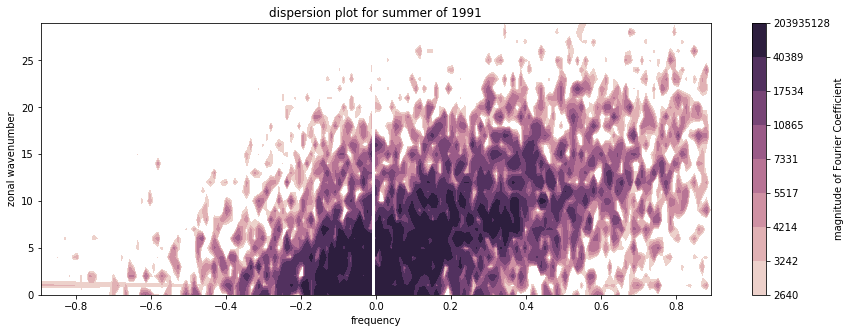

In [100]:
#set colors and levels for discrete values
level_set = [np.percentile(Z, i*5) for i in range(1,21)]
level_set_less = [np.percentile(Z, i*5) for i in range(1,21) if i*5 >= 60]
colors_set = cubehelix_palette(8)

#plot it
plt.clf();
plt.figure(figsize=(15, 5));

#actual plot
CF = plt.contourf(X,Y,Z, levels = level_set_less, colors = colors_set)

#set colorbars
CBI = plt.colorbar(CF, label = "magnitude of Fourier Coefficient")
labels = [int(entry) for entry in level_set_less]
CBI.set_ticklabels(labels)

#plot labels
plt.xlabel("frequency")
plt.ylabel("zonal wavenumber")
plt.title("dispersion plot for " + names_matched[50][1] + " of " + str(names_matched[50][0]))

name = 'disp_plots/test_01' + names_matched[50][1] + "_" +str(names_matched[50][0]) + '.png'
plt.savefig(name)

plt.show()

In [138]:
len("no")

2

In [166]:
def disp_plot(X,Y,Z,name_ind, levels = "no", year = 'no'):
    #make this plotting into a function
    
    if len(levels) == 2:
        #set colors and levels for discrete values
        level_set = [np.percentile(Z, i*5) for i in range(1,21)]
        level_set_less = [np.percentile(Z, i*5) for i in range(1,21) if i*5 >= 60]
    else:
        level_set_less = levels
    
    colors_set = cubehelix_palette(8)

    #plot it
    plt.clf();
    plt.figure(figsize=(15, 5));

    #actual plot
    CF = plt.contourf(X,Y,Z, levels = level_set_less, colors = colors_set)

    #set colorbars
    CBI = plt.colorbar(CF, label = "magnitude of Fourier Coefficient")
    labels = [int(entry) for entry in level_set_less]
    CBI.set_ticklabels(labels)

    #plot labels
    plt.xlabel("frequency")
    plt.ylabel("zonal wavenumber")
    

    if len(year) == 2:
        name = 'disp_plots/v02_disp_' + names_matched[name_ind][1] + "_" +str(names_matched[name_ind][0]) + '.png'
        title = "dispersion plot for " + names_matched[name_ind][1] + " of " + str(names_matched[name_ind][0])
    else:
        name = 'disp_plots/v02_disp_avg_' + year + '.png'
        title = "dispersion plot for " + year
        
    
    plt.title(title)
    plt.savefig(name)
    
    plt.close()

In [167]:
def plotprep(data, max_z = 30, max_f = 0.9):
    #prep data for plotting
    
    #crop the data, only keep the positive wavenumbers
    cropped = [[data[i][j] for i in range(len(zonal_spacing)) 
                if zonal_spacing[i] < max_z and zonal_spacing[i] >= 0]
               for j in range(len(frequencies)) 
               if np.abs(frequencies[j]) < max_f]

    cropf = [counted for counted in frequencies if np.abs(counted) < max_f]# and counted != 0]
    cropz = [zonal_spacing[i] for i in range(len(zonal_spacing)) 
                if zonal_spacing[i] < max_z and zonal_spacing[i] >= 0]
    
    x = cropf
    y = cropz
    X, Y = np.meshgrid(x,y)
    X = np.flip(X)
    Z = np.transpose(np.abs(np.real(cropped)))
    
    return X,Y,Z

In [168]:
def plotr_d(index, max_z = 30, max_f = 0.9, levels = "no", year = "no"):
    
    data = d2_trans[index]
    X,Y,Z = plotprep(data, max_z, max_f)
    disp_plot(X,Y,Z,index, levels)

In [169]:
#get mean values for level setting/colors
levels_avg = []
for entry in d2_trans:
    X,Y,Z = plotprep(entry)
    
    level_set_less = [np.percentile(Z, i*5) for i in range(1,21) if i*5 >= 60]
    levels_avg.append(level_set_less)
    
#get average list length
averaged_levels = np.average(levels_avg, axis = 0)

In [170]:
#make plots for individual seasons
for i in range(len(d2_trans)):
    plotr_d(i, levels = averaged_levels)

<Figure size 432x288 with 0 Axes>

In [174]:
#get the average for each season
d2_seasons = [[d2_trans[i] for i in range(len(d2_trans)) 
               if names_matched[i][1] == part] for part in seasons]
d2_averages = np.average(d2_seasons, axis = 1)

#get better mean levels
#get mean values for level setting/colors
levels_avg = []
for entry in d2_averages:
    X,Y,Z = plotprep(entry)
    
    level_set_less = [np.percentile(Z, i*5) for i in range(1,21) if i*5 >= 60]
    levels_avg.append(level_set_less)
    
#get average list length
averaged_levels_seasonal = np.average(levels_avg, axis = 0)

#plot the averages for each season
for i in range(len(seasons)):
    
    data = d2_averages[i]
    X,Y,Z = plotprep(data)
    
    disp_plot(X,Y,Z,1, levels = averaged_levels_seasonal, year = seasons[i])

<Figure size 432x288 with 0 Axes>